In [1]:
import matplotlib.pyplot as plt
plt.style.use('notebook.mplstyle')
import numpy as np

# Radioactive Decay: Revisited

Text(0, 0.5, 'Decay Rate (Bq)')

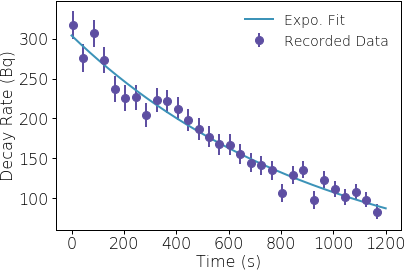

In [2]:
from scipy.optimize import curve_fit
t, decay_rate, σ = np.loadtxt('decay.dat', unpack=True, comments='#')
plt.errorbar(t,decay_rate ,yerr=σ, marker='o', linestyle='None', label='Recorded Data' )
def exp_func(x,*a):
    '''exponential function'''
    return (a[0]*np.exp(a[1]*x))

t_fit = np.linspace(0,1200, 1000)
# using weighted least squares fit by passing our error
a, acov = curve_fit(exp_func, t,decay_rate, p0=(0,0), sigma=σ)
plt.plot(t_fit, exp_func(t_fit,*a), label='Expo. Fit')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Decay Rate (Bq)')

In [3]:
# calculating half life
mystery_el = lambda t: exp_func(t, *a)
initial_mass = mystery_el(0)
# test goodness of fit
def χ2(x,y,Y,σ=None):
    '''Return the value of χ².'''
    if σ.any():
        return np.sum(((Y-y)/σ)**2)
    else: 
        return np.sum((Y-y)**2)
    
gof = χ2(t,decay_rate, exp_func(t,*a), σ=σ)
if gof < 2:
    gof_string ='Pretty good!'
else: 
    gof_string = 'Yikes, not so good.'
print(f'χ2 GOF test result: {gof}\n{gof_string}')
# calculate half life
half_life = np.log(2)/-a[1]
print(f'Calculated half life: {half_life}')

χ2 GOF test result: 24.455499326221066
Yikes, not so good.
Calculated half life: 665.6996374333204


# Analysis of Sunspot Data

### a) Graph the sunspot number versus time

Text(0.5, 0, 'Year with fractional month')

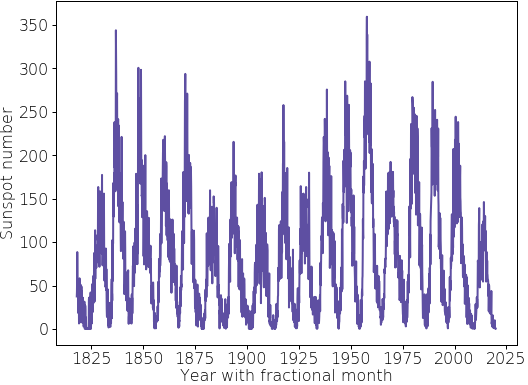

In [44]:
# Column 1-2: Gregorian calendar date
# - Year
# - Month
# Column 3: Date in fraction of year for the middle of the corresponding month
# Column 4: Monthly mean total sunspot number.
# Column 5: Monthly mean standard deviation of the input sunspot numbers from individual stations.
# Column 6: Number of observations used to compute the monthly mean total sunspot number.
# Column 7: Definitive/provisional marker. A blank indicates that the value is definitive. A '*' symbol indicates that the monthly value is still provisional and is subject to a possible revision (Usually the last 3 to 6 months)
year, month, ym_frac, mean_ssn, std_ssn, num_obs = np.loadtxt('SN_m_tot_V2.0.txt', unpack=True, skiprows=829) # we skip these rows because the standard deviation was not recorded 
plt.figure(figsize=(8,6))
plt.plot(ym_frac, mean_ssn)
plt.ylabel('Sunspot number')
plt.xlabel('Year with fractional month')

### b) Fit the data with a straight line and estimate the yearly rate of change of sunspot number

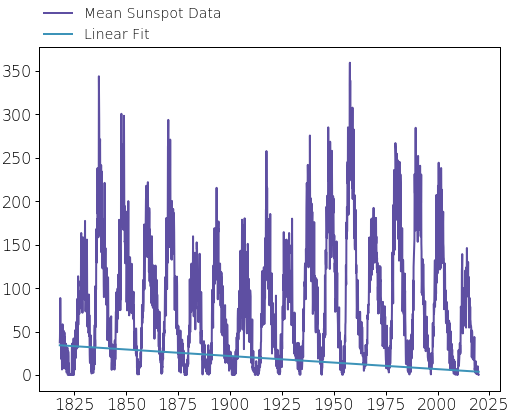

In [23]:
 # linear fit from class
def Σ(σ,q):
    '''Compute the Σ function needed for linear fits.'''
    return np.sum(q/σ**2)

def get_a(x,y,σ):
    '''Get the χ^2 best fit value of a0 and a1.'''

    # Get the individual Σ values
    Σy,Σx,Σx2,Σ1,Σxy = Σ(σ,y),Σ(σ,x),Σ(σ,x**2),Σ(σ,np.ones(x.size)),Σ(σ,x*y)

    # the denominator
    D = Σ1*Σx2 - Σx**2

    # compute the best fit coefficients
    a = np.array([Σy*Σx2 - Σx*Σxy,Σ1*Σxy - Σx*Σy])/D

    # Compute the error in a
    aErr = np.array([np.sqrt(Σx2/D),np.sqrt(Σ1/D)])

    return a,aErr
a, a_err = get_a(ym_frac, mean_ssn, std_ssn)
def linear(x, *a):
    return a[0] + a[1]*x
plt.figure(figsize=(8,6))
plt.plot(ym_frac, mean_ssn, label='Mean Sunspot Data') 
plt.plot(ym_frac, linear(ym_frac, *a), label='Linear Fit')
plt.legend(loc=(0,1))


### c) Remove the linear trend from the data and compute and plot the power spectrum

Text(0, 0.5, 'Power [arb]')

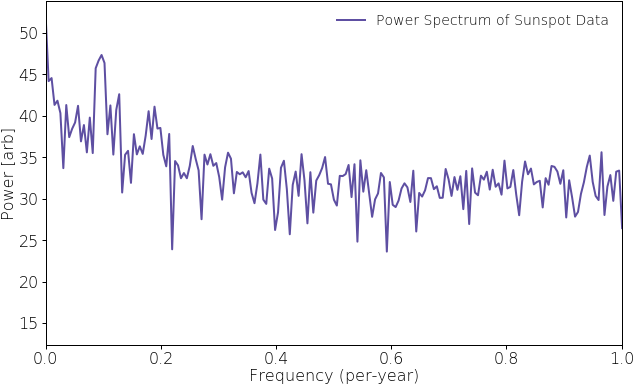

In [42]:
from numpy.fft import fft, fftfreq
fig = plt.figure(figsize=(10,6))
spec = fft(mean_ssn-linear(ym_frac, *a))
f = fftfreq(len(ym_frac), ym_frac[1]-ym_frac[0])
power = 10*np.log10(np.abs(spec))
plt.plot(f[0:len(power)//2], power[0:len(power)//2], label='Power Spectrum of Sunspot Data')
plt.legend()
plt.xlim(0,1)
plt.xlabel('Frequency (per-year)')
plt.ylabel('Power [arb]')

### d)  Use what you have learned about signal processing to analyze the results. Does the data contain any interesting patterns/features?
Inspecting the power spectrum plot, we can see that there is a peak right around 0.1 per-years.  We can interpret that as our sunspot data has a period of around 10 years.  If we take a look at the sunspot vs time plot, we notice that there is indeed a peak around every 10 years. There are tons of other frequencies in the power spectrum, but they are all much lower power than the fundemental frequency.

After a quick google search wikipedia confirms our analysis, stating that sunspot numbers vary according to the 11-year solar cycle. 


# Progress on GPU FFT code
After clearing up a few setbacks figuring out how to use the DeepGreen Jupyter notebook, things have been going quite smoothly.  I spent a few hours learning the ins and outs of the python package Reikna, which uses PyCuda and PyOpenCL to interface with the GPU.  

There are  two main tools in the Reikna Package, computations and transformations.  Computations (such as the FFT) conduct the main processes of your code.  Transformations help to format input and/or output.  Examples of transformations are multiply by constant, norm of constant, split complex values, etc.  Find below a visual of a 'transformation tree'.  The main block is the computation, while at each input/output port transformations can be attached.   
<img src='transformation_tree.png' width=500px>

So far, I have implemented a FFT computation with a couple of pre-defined transformations.  I am currently using a signal I have created, but I plan on collecting some IQ (complex) data to input into this code.  To fully demonstrate the ability of the GPU, I would like to perform several very large windowed FFTs for spectral analysis of radio signals. This will require creating some of my own transformations for processing like converting to dB, windowing, and appling overlaps (similar to that of the scipy.signal.welch).

### Updated Project Goals
 - Allow for multiple size FFTs
 - Automatically create a window for the appropriate FFT size
 - Implement a 50% overlap on the desired FFT
 - Compare results to scipy.signal.welch, a scipy function capable of performing the same measurement

### Milestones and Timeline
 - Learn the basics of PyCuda and Reikna (done)
 - Implement single FFT of a certain size (done)
 - Nov, 22: Create windowing transformation
 - Nov, 27: Create 50% overlap transformation
 - Dec, 4: Conduct comparisons of scipy welch function and GPU code
 - Dec, 9: Turn in final report and present work
### References 
 - B. Opanchuk, “Reikna, a pure Python GPGPU library¶,” Reikna, a pure Python GPGPU library - reikna 0.8.0 dev.9e0b7dc documentation. [Online]. Available: http://reikna.publicfields.net/en/latest/.
 
 - Andreas Klöckner, Nicolas Pinto, Yunsup Lee, Bryan Catanzaro, Paul Ivanov, Ahmed Fasih, PyCUDA and PyOpenCL: A scripting-based approach to GPU run-time code generation, Parallel Computing, Volume 38, Issue 3, March 2012, Pages 157-174.